Código para la creación de imagen tiff con metadatos de drone

In [11]:
from PIL import Image
from PIL.TiffTags import TAGS
import re
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.transform import Affine
import numpy as np 
import cv2
import imutils
import matplotlib.pyplot as plt

# %Crear Dicciónario de metadata de las imágenes %

In [14]:
# Nombre de la imagen

imagen = "Img/DJI_0041.TIF"
#imagen = "Img_rotado/drone_rot_DJI_0051.TIF"

n_imagen = imagen.split("/")[-1]
n_imagen = n_imagen.split(".")[0]
n_imagen



'DJI_0041'

In [15]:
with rasterio.open(imagen) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()
    
    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            "+proj=latlong",'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)
    r = Affine.rotation(50)

c:\Users\LUIS GUTIERREZ\Desktop\IA\RotarImagen\rotarimagen-env\Lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'type': 'Polygon', 'coordinates': [[[0.0, 0.0], [0.0, 1300.0], [1600.0, 1300.0], [1600.0, 0.0], [0.0, 0.0]]]}


In [16]:
# obtenemos la imagen .tif

img = Image.open(imagen)
# obtenemos los Tags de la metadata y se almacenan en un diccionario
meta_dict = {TAGS[key]: img.tag[key] for key in img.tag_v2}
# Se imprime el diccionario para obtener la composición de los datos
# for rec in meta_dict:
#     print(rec, ":", meta_dict[rec])

# Extraemos el indicador xmp
p = meta_dict.get("XMP")
s = p.decode("UTF-8")
# dividimos por el salto de linea y obtenemos una lista
div = s.split("\n")

#eliminamos los espacios vacios 

for ind,recorrido in enumerate(div):
    div[ind]=recorrido.strip() 
usar = div[17]

result = re.search(":(.*)=", div[17])
result.group(1)

result2 = re.search("\"(.*)\"", div[17])
result2.group(1)

metadiccionario = {}
for ind,recorrido in enumerate(div):
    try:
        metadiccionario[re.search(":(.*)=", div[ind]).group(1)] = re.search("\"(.*)\"", div[ind]).group(1)
    except:
        pass

metadiccionario = {}
for ind,recorrido in enumerate(div):
    try:
        metadiccionario[re.search(":(.*)=", div[ind]).group(1)] = re.search("\"(.*)\"", div[ind]).group(1)
    except:
        pass

print(metadiccionario)

{'xmpmeta xmlns:x': 'adobe:ns:meta/', 'RDF xmlns:rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#', 'Description rdf:about': 'DJI Meta Data', 'tiff': 'http://ns.adobe.com/tiff/1.0/', 'exif': 'http://ns.adobe.com/exif/1.0/', 'xmp': 'http://ns.adobe.com/xap/1.0/', 'xmpMM': 'http://ns.adobe.com/xap/1.0/mm/', 'dc': 'http://purl.org/dc/elements/1.1/', 'crs': 'http://ns.adobe.com/camera-raw-settings/1.0/', 'drone-dji': 'http://www.dji.com/drone-dji/1.0/', 'Camera': 'http://pix4d.com/camera/1.0', 'ModifyDate': '2022-02-11', 'CreateDate': '2022-02-11', 'Make': 'DJI', 'Model': 'FC6360', 'format': 'image/TIF', 'AbsoluteAltitude': '+84.74', 'RelativeAltitude': '+70.02', 'GpsLatitude': '11.22618336', 'GpsLongitude': '-74.18539502', 'GimbalRollDegree': '+0.00', 'GimbalYawDegree': '-96.60', 'GimbalPitchDegree': '-89.90', 'FlightRollDegree': '+9.00', 'FlightYawDegree': '-94.10', 'FlightPitchDegree': '+11.20', 'FlightXSpeed': '+0.20', 'FlightYSpeed': '+0.70', 'FlightZSpeed': '+0.00', 'CamReverse': '

## *Extracción de los datos significativos de la metadata*

In [17]:

centro_x = float(metadiccionario["CalibratedOpticalCenterX"])
centro_y = float(metadiccionario["CalibratedOpticalCenterY"])
altura_vuelo = float(metadiccionario["RelativeAltitude"])
distancia_focal = float(metadiccionario["CalibratedFocalLength"])
angulo_giro = float(metadiccionario["GimbalYawDegree"])
latitud = float(metadiccionario["GpsLatitude"])
longitud = float(metadiccionario["GpsLongitude"])

#print(float(metadiccionario["GimbalYawDegree"]))

#Se calcula la resolución en metros por pixel.
#Es decir, a cuantos metros equivale un pixel
resolucion = altura_vuelo/distancia_focal
print(f"Resolución = {resolucion}")

#rotado=img.rotate(math.degrees(float(metadiccionario["GimbalYawDegree"])))



Resolución = 0.03659581803751048


### Se utiliza la rotación para crear nuevas imágenes y se abren en otra variable(Temporal)
Proyectividad: Reemplaza la misma imágen de entrada con la rotación correspondiente para que la imágen quede geoposicionadamente con el mismo nombre

Image.rotate(angle, resample=Resampling.NEAREST, expand=0, center=None, translate=None, fillcolor=None)[source]

- Angle= angulo
- Expand = Hace la imágen mas grande para que cuando gira no se corta
- fillCollor = Rellena con cualquier color la función

In [7]:
# Utilizamos en angulo que se usa
rotado = img.rotate(
    (float(metadiccionario["GimbalYawDegree"]))*-1, expand=True)
# Guardamos con el nombre el nuevo .TIF con el imágen rotada
rotado.save("img_rotado/rotado_"+n_imagen+".tif")
imagen2 = "img_rotado/rotado_"+n_imagen+".tif"


In [24]:
def rotar_imagen(img, angulo = 0):
    # Dimensiones de la imagen original
    y, x = img.shape[:2]  # Donde 'y' son las filas y 'x' son las columnas

    capa_blanco = 255*np.ones((y, x, 1), dtype=np.int8)

    img_4 = 255*np.ones((y, x, 4), dtype=np.int8)  # Matriz de (y, x , 4)

    #print(img.shape)
    #print(capa_blanco.shape)
    #print(img_4.shape)

    img_4[:, :, 0] = img[:, :, 0]  # Blue
    img_4[:, :, 1] = img[:, :, 1]  # Green
    img_4[:, :, 2] = img[:, :, 2]  # Red
    img_4[:, :, 3] = capa_blanco[:, :, 0]

    m = imutils.rotate_bound(img_4, angulo)
    plt.imshow(m)

    # cv2.imshow("window_name", m)

    # # waits for user to press any key
    # # (this is necessary to avoid Python kernel form crashing)
    # cv2.waitKey(0)

    # # closing all open windows
    # cv2.destroyAllWindows()
    
    return (m, y, x)


1600 1300


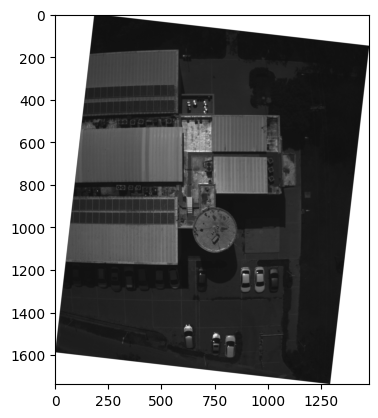

In [30]:
angulo = (float(metadiccionario["GimbalYawDegree"]))*-1
img_o =  cv2.imread("Img/"+n_imagen+".TIF",1)
img, y, x = rotar_imagen(img_o, angulo)

cv2.imwrite("Img_rotado/"+n_imagen+".png", img)
imagen2 = "Img_rotado/"+n_imagen+".png"

print(x, y)


In [8]:
# Abrimos ahora la segunda imágen, la cual es la nueva creada
with rasterio.open(imagen2) as src:
    # Obtener la información de la imagen
    width = src.width
    height = src.height
    transform = src.transform
    crs = src.crs
    print(src.res)
    print("width:", width)
    print(src.transform)


(1.0, 1.0)
width: 1474
| 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|


c:\Users\LUIS GUTIERREZ\Desktop\IA\RotarImagen\rotarimagen-env\Lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Cálculo de las coordenadas de las esquinas la imagen

Se divide entre 111111 para convertir los metros en grados. Esto se debe a que 1 grado de longitud o latitud en el ecuador es aproximadamente 111.111 km de ancho. Dado que la longitud y la latitud son medidas en grados, se debe convertir el tamaño de los píxeles en metros a grados para poder calcular las coordenadas extremas en grados.
Donde el ancho de la imagen en metros se divide entre la distancia en metros por grado para obtener la diferencia en grados. El factor 111111 es una aproximación, ya que la distancia en metros por grado varía según la latitud. Sin embargo, esta aproximación es suficiente para una precisión razonable.

Es importante tener en cuenta que esta conversión solo es válida para latitudes cercanas al ecuador, ya que la distancia en metros por grado varía según la latitud.

In [31]:
# Se geoposiciona la imágen y ahora
# Calcular las coordenadas de los extremos en metros
min_lon = float(metadiccionario["GpsLongitude"]) - (
    float(metadiccionario["CalibratedOpticalCenterX"]) * resolucion) / 111111
max_lon = float(metadiccionario["GpsLongitude"]) + (
    float(metadiccionario["CalibratedOpticalCenterX"]) * resolucion) / 111111
min_lat = float(metadiccionario["GpsLatitude"]) - (
    float(metadiccionario["CalibratedOpticalCenterY"]) * resolucion) / 111111
max_lat = float(metadiccionario["GpsLatitude"]) + (
    float(metadiccionario["CalibratedOpticalCenterY"]) * resolucion) / 111111
print(min_lon, max_lon, min_lat, max_lat)

transform = rasterio.transform.from_bounds(
    min_lon, min_lat, max_lon, max_lat, img.width, img.height)
""" print(transform)
print("#"*10) """
# Abrir el archivo original
with rasterio.open(imagen2) as src:
    # Leer los datos de la imagen
    image = src.read()

    # Crear una copia del archivo
    with rasterio.open(
        "Img_rotado/drone_rot_"+n_imagen+".TIF",  # Nombre del nuevo archivo georefenciado
        'w',
        driver='GTiff',
        height=src.height,
        width=src.width,
        count=1,
        dtype="float64",
        crs={"init": "epsg:4326"},
        transform=transform,
    ) as dst:
        dst.write(image)


-74.18565851015336 -74.18513152984664 11.225969274250396 11.226397445749605


c:\Users\LUIS GUTIERREZ\Desktop\IA\RotarImagen\rotarimagen-env\Lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


ValueError: Source shape (4, 1738, 1475) is inconsistent with given indexes 1